In [1]:

import torch
import torch.nn as nn
import einops
import math



class simplenet(nn.Module):
    def __init__(self):
        super(simplenet,self).__init__()
        self.vecs=nn.Parameter(torch.randn([12],requires_grad=True))
        
    
    def forward(self):
        a,b,c,d=self.vecs.chunk(4)
        return torch.einsum('i,j->ij',a,b)+torch.einsum('i,j->ij',c,d)
    

class simplernet(nn.Module):
    def __init__(self,n):
        super(simplernet,self).__init__()
        self.a=nn.Parameter(torch.randn([n],requires_grad=True)/1.0)
        self.b=nn.Parameter(torch.randn([n],requires_grad=True)/1.0)
        self.c=nn.Parameter(torch.randn([n],requires_grad=True)/1.0)
        self.d=nn.Parameter(torch.randn([n],requires_grad=True)/1.0)
        
    
    def forward(self):
        return torch.einsum('i,j->ij',self.a,self.b)+torch.einsum('i,j->ij',self.c,self.d)
    

        



class biggerNet(nn.Module):
    def __init__(self,dim,num):
        super(biggerNet,self).__init__()
        self.cols=nn.Parameter(torch.randn([num,dim],requires_grad=True,dtype=torch.float32)/math.sqrt(num))
        self.rows=nn.Parameter(torch.randn([num,dim],requires_grad=True,dtype=torch.float32)/math.sqrt(num))

    def forward(self):
        outer=torch.einsum('ij, ik -> ijk',self.cols,self.rows)
        return outer.sum(dim=0)
        


In [ ]:
model=biggerNet(3,20)
model()
(model.rows.norm(2,dim=1)*model.cols.norm(2,dim=1)).sqrt().detach().numpy()

array([0.26230884, 0.3357203 , 0.2036532 , 0.39317602, 0.34981224,
       0.23194468, 0.35149246, 0.2701878 , 0.28628075, 0.55980575,
       0.3431646 , 0.1895501 , 0.20602353, 0.48316655, 0.3648572 ,
       0.45552692, 0.10852868, 0.41295424, 0.6547695 , 0.2648464 ],
      dtype=float32)

In [ ]:
import numpy as np
from tqdm import trange,tqdm
torch.manual_seed(7923)

model=biggerNet(12,10)

K=torch.randn([12,1],requires_grad=False)
Q=torch.randn([12,1],requires_grad=False)
Teach=Q @ K.T

K=torch.randn([12,1],requires_grad=False)
Q=torch.randn([12,1],requires_grad=False)

Teach += Q @ K.T

optimizer=torch.optim.AdamW(model.parameters(),lr=0.05,weight_decay=0*1e-1,amsgrad=True)

epochs=30000


norm_arr=[]
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    loss=torch.norm(model()-Teach,2)**2
    # print(loss)
    # loss+=0.01*torch.norm(model.vecs,1)
    # norms=torch.norm(model.vecs.view(4,3),2,dim=1).view(2,2).prod(dim=1).sqrt()
    # norms=[(model.a.norm()*model.b.norm()),(model.c.norm()*model.d.norm())]
    # norms=[(model.b.norm()),(model.d.norm())]
    # loss+=0.1* torch.tensor(norms).sum()
    norms=(model.rows.norm(2,dim=1)*model.cols.norm(2,dim=1)).sqrt().detach().numpy()
    norm_arr.append(norms)

    loss.backward()
    optimizer.step()


    if (epoch+1)%30000==0:
        print(f'epoch: {epoch+1}\t|\tloss: {loss.log10().item():.2f}\t|\tnorms: '+np.array2string(np.log10(norms), precision=1, floatmode='fixed'))#\t|\tnorms: {norms[0]:.2f}, {norms[1]:.2f}')

epoch: 30000	|	loss: -12.38	|	norms: [ 0.3  0.1  0.3  0.3  0.2  0.4  0.2 -0.3 -0.2  0.2]


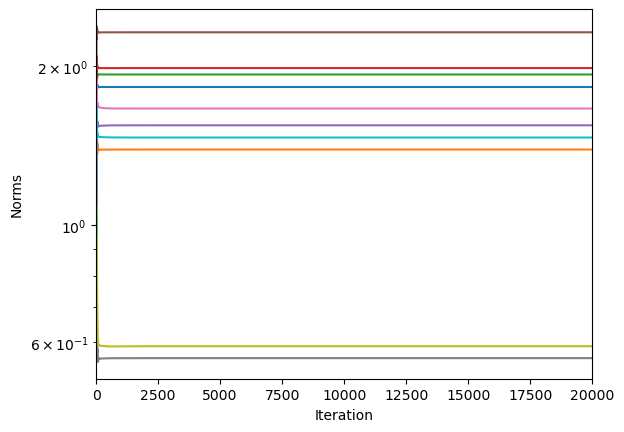

In [ ]:
import matplotlib.pyplot as plt

for line in np.array(norm_arr).T:
    plt.plot(line)

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Norms')
# plt.ylim(1e-5,10)
plt.xlim(0,20000)
plt.show()

In [ ]:
(1-model().detach()/Teach).abs().log10().view(-1).sort().values

tensor([   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf, -7.2247, -7.2247, -7.2247, -7.2247, -7.2247, -7.2247,
        -7.2247, -7.2247, -7.2247, -7.2247, -7.2247, -7.2247, -7.2247, -7.2247,
        -7.2247, -6.9237, -6.9237, -6.9237, -6.9237, -6.9237, -6.9237, -6.9237,
        -6.9237, -6.9237, -6.9237, -6.92

In [ ]:
class short(nn.Module):
    def __init__(self):
        super(short,self).__init__()
        self.y=nn.Parameter(torch.randn([1],requires_grad=True,dtype=torch.double))
        self.x=nn.Parameter(torch.randn([1],requires_grad=True,dtype=torch.double))
       
        self.t1=nn.Parameter(torch.randn([1],requires_grad=True,dtype=torch.double))
        self.t2=nn.Parameter(torch.randn([1],requires_grad=True,dtype=torch.double))
        self.q1=nn.Parameter(torch.randn([1],requires_grad=True,dtype=torch.double))
        self.q2=nn.Parameter(torch.randn([1],requires_grad=True,dtype=torch.double))
        
    
    def forward(self,input):
        T1=torch.cos(self.t1)
        T2=torch.cos(self.t2)
        Q1=torch.cos(self.q1)
        Q2=torch.cos(self.q2)

        T12=torch.cos(self.t1-self.t2)
        Q12=torch.cos(self.q1-self.q2)

        return 1+self.x**2+self.y**2-2*self.x*T1*Q1-2*self.y*T2*Q2+2*self.x*self.y*T12*Q12
    



In [ ]:
model=short()

optimizer=torch.optim.SGD(model.parameters(),lr= 10)

for i in range(20):
    model.train()
    optimizer.zero_grad()

    loss=model(1).sum()
    
    optimizer.step()

    print(loss.item())

1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287


In [ ]:
# model=short()
model.train()
loss=model(None).sum()
loss.backward()
oprimizer.step()
for name, param in model.named_parameters():
    print(name, param.grad.item(), param.item())



y -4.382595385615131 -0.011813331989359764
x -11.365170701502864 -0.04147588133806347
t1 -0.12328021247151669 0.27765189142157204
t2 -0.13743348349124382 1.2311498137139976
q1 -0.17087148749312517 0.3617193944205535
q2 0.0057330334781476155 -0.09005317162602089


In [ ]:
import torch
import torch.nn as nn

class Short(nn.Module):
    def __init__(self):
        super(Short, self).__init__()
        self.y = nn.Parameter(torch.tensor(0.01, requires_grad=True, dtype=torch.double))#nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.double))
        self.x = nn.Parameter(torch.tensor(1.1, requires_grad=True, dtype=torch.double))#nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.double)/100)
        self.t1 = nn.Parameter(torch.tensor(0, requires_grad=True, dtype=torch.double))
        self.t2 = nn.Parameter(torch.tensor(0, requires_grad=True, dtype=torch.double))
        self.q1 = nn.Parameter(torch.tensor(0, requires_grad=True, dtype=torch.double))
        self.q2 = nn.Parameter(torch.tensor(0, requires_grad=True, dtype=torch.double))
        
    def forward(self):
        T1 = torch.cos(self.t1)
        T2 = torch.cos(self.t2)
        Q1 = torch.cos(self.q1)
        Q2 = torch.cos(self.q2)
        T12 = torch.cos(self.t1 - self.t2)
        Q12 = torch.cos(self.q1 - self.q2)
        return 1 + self.x**2 + self.y**2 - 2 * self.x.abs() * T1 * Q1 - 2 * self.y.abs() * T2 * Q2 + 2 * self.x.abs() * self.y.abs() * T12 * Q12
    

model = Short()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)  # Consider reducing the learning rate

for i in range(1000):
    model.train()
    optimizer.zero_grad()

    loss = model().sum()  # Changed to call the forward method without an argument
    loss+= (model.x.abs().sum()+model.y.abs().sum())/100
    
    loss.backward()  # This is necessary to compute the gradients
    optimizer.step()

    if (i+1)%100:
        print(loss.item())


model.x,model.y

0.0232
0.019000000000000156
0.014736000000000067
0.013224000000000154
0.011688959999999776
0.011144639999999923
0.010592025600000433
0.010396070400000084
0.010197129215999743
0.010126585344000003
0.01005496651776015
0.010029570723840135
0.01000378794639368
0.00999464546058247
0.009985363660701527
0.009982072365809756
0.009978730917852601
0.00997754605169131
0.009976343130426862
0.009975916578609145
0.00997548352695359
0.009975329968299234
0.009975174069703498
0.009975118788587672
0.009975062665093109
0.009975042763891698
0.00997502255943356
0.009975015395000956
0.009975008121396118
0.009975005542200327
0.009975002923702575
0.009975001995192018
0.009975001052533008
0.009975000718269168
0.009975000378911842
0.00997500025857712
0.00997500013640826
0.00997500009308744
0.009975000049106892
0.00997500003351165
0.009975000017678506
0.00997500001206409
0.009975000006364433
0.009975000004343057
0.009975000002291082
0.009975000001563546
0.009975000000824748
0.00997500000056271
0.0099750000002969

(Parameter containing:
 tensor(0.9950, dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor(-2.4672e-17, dtype=torch.float64, requires_grad=True))

In [3]:
import torch

tn=torch.zeros([2,3,3])

In [17]:
lorentz_gens=torch.zeros([6,4,4], dtype=torch.float32)
sig_mat=torch.tensor([[0,-1],[1,0]],requires_grad=False, dtype=torch.float32).view(-1)

# Rotations
lorentz_gens[0,[2,2,3,3],[2,3,2,3]]=sig_mat
lorentz_gens[1,[3,3,1,1],[3,1,3,1]]=sig_mat
lorentz_gens[2,[1,1,2,2],[1,2,1,2]]=sig_mat

# Bosts
lorentz_gens[3,[0,0,1,1],[0,1,0,1]]=sig_mat.abs()
lorentz_gens[4,[0,0,2,2],[0,2,0,2]]=sig_mat.abs()
lorentz_gens[5,[0,0,3,3],[0,3,0,3]]=sig_mat.abs()


In [20]:
inputs.shape

torch.Size([2, 3, 4])

In [35]:
import torch

# Create an example input tensor of shape [d, e, f]
# inputs = torch.randn(2, 3, 4, requires_grad=True)

torch.norm(inputs.view(-1),2)**2, (inputs**2).sum(), (torch.norm(inputs,2,dim=-1)**2).sum()

(tensor(11.2790, grad_fn=<PowBackward0>),
 tensor(11.2790, grad_fn=<SumBackward0>),
 tensor(11.2790, grad_fn=<SumBackward0>))

In [83]:
import sys
import os
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad
import torch.nn.functional as F

sys.path.append('../python')

 
from Lorentz_loss import LorentzLoss



sys.path.append('..')

In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
import einops

class LorentzInvariantModel(nn.Module):
    """A simple model that outputs a Lorentz scalar x^T η x."""
    def __init__(self):
        super(LorentzInvariantModel, self).__init__()
        # Minkowski metric η
        self.eta = torch.tensor([1, -1, -1, -1], dtype=torch.float32)

    def forward(self, x):
        # Reshape x to [B, N, 4] where N is number of 4-vectors
        x = einops.rearrange(x, 'B (N d) -> B N d', d=4)
        # Compute x_i^T η x_j for each 4-vector
        return torch.einsum('B n i, i, B k i -> B n k', x, self.eta, x).view(x.shape[0],-1).prod(dim=1)

# Initialize the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = LorentzInvariantModel().to(device)




In [2]:
# Test input tensor (Batch size = 2, each input is 4-dimensional, 2 particles)
test_input = torch.randn([10,8], dtype=torch.float32, device=device)
print(model(test_input))

# Lorentz loss instance for scalar output
            zz = LorentzLoss(device=device, model=model)


test_input.requires_grad = True

# Compute Lorentz loss for scalar case
loss = lorentz_loss(test_input, spin='scalar')

print("Lorentz Scalar Loss:", loss.item())

tensor([ 1.9026e+02, -1.2128e-02, -8.2789e-04,  1.0567e+01,  2.9529e+01,
         6.3967e+00, -6.8485e-01,  1.9221e+00, -1.3382e+00, -1.2791e+00])


NameError: name 'LorentzLoss' is not defined

In [27]:
a=[1,2,3,4]
a[1:]+a[:1]

[2, 3, 4, 1]

In [34]:
len(''[1:])

0

# A 4 vector try

In [8]:
class block(nn.Module):
    def __init__(self,d_in,d_out,bias=True):
        super(block,self).__init__()
        self.fc = nn.Linear(d_in,d_out,bias=bias)
        
    def forward(self,x):
        x = self.fc(x)
        x = nn.functional.relu(x)
        return(x)

class CrazyModel(nn.Module):
    def __init__(self):
        super(CrazyModel,self).__init__()

        self.blocks = nn.Sequential(
            block(4,10),
            block(10,10),
            block(10,10),
            block(10,1),
            )
    def forward(self,x):
        return self.blocks(x)
    





In [9]:
def scalar_val(tensor):
    # assume shape [B,N,4]
    eta = torch.tensor([1, -1, -1, -1])
    xx= torch.einsum('B N i, i ,B N i -> B N',tensor,eta,tensor)

    return (xx + xx**2/4)/math.sqrt(21)

data = torch.randn([1,100000,4])
labels = scalar_val(data)

model=CrazyModel()

In [21]:
iters = 1000
model.train()
loss=nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(),lr=1)

for iter in range(iters):

    preds = model(data).squeeze(-1)
    out = loss(preds,labels)
    
    optimizer.zero_grad()
    out.backward()
    optimizer.step()

    if iter%100==0:
        print(f'iter:{iter}\t|\tloss:{out.item()}')


    

iter:0	|	loss:0.9897177219390869
iter:100	|	loss:0.9897177219390869
iter:200	|	loss:0.9897177219390869
iter:300	|	loss:0.9897177219390869
iter:400	|	loss:0.9897177219390869
iter:500	|	loss:0.9897177219390869


KeyboardInterrupt: 

In [59]:

import torch
import torch.nn as nn
import math

def scalar_val(tensor):
    # assume shape [B,N,4]
    eta = torch.tensor([1, -1, -1, -1])
    xx = torch.einsum('B N i, i, B N i -> B N', tensor, eta, tensor)
    return (xx + xx**2/4) / math.sqrt(21)

# Generate data and labels
data = torch.randn([1, 10000, 4])
labels = scalar_val(data)

class Block(nn.Module):
    def __init__(self, d_in, d_out, bias=True):
        super(Block, self).__init__()
        self.fc = nn.Linear(d_in, d_out, bias=bias)
        
    def forward(self, x):
        x = self.fc(x)
        x = nn.functional.gelu(x)
        return x

class CrazyModel(nn.Module):
    def __init__(self):
        super(CrazyModel, self).__init__()
        self.blocks = nn.Sequential(
            Block(4, 10),
            Block(10, 10),
            Block(10, 10),
            Block(10, 1),
        )

        self.extand1 = nn.Linear(1,4)
        self.bi_lin = nn.Linear(4,4,bias=False)
        self.lin = nn.Linear(4,4)

    def forward(self, x):
        A = torch.einsum('...i,...i->...',self.bi_lin(x),x).unsqueeze(-1)
       
        x = self.extand1(A)+self.lin(x)
        return self.blocks(x)

# Initialize model, loss, and optimizer
model = CrazyModel()
iters = 10000
model.train()
loss = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-2,  weight_decay=1e-2)

for iter in range(iters):
    preds = model(data).squeeze(-1)
    out = loss(preds, labels)
    
    optimizer.zero_grad()
    out.backward()
    optimizer.step()

    if (iter % 1000 == 0 and iter>0) or iter == 100 or iter ==500:
        print(f'iter: {iter}\t|\tloss: {out.item()}')


iter: 100	|	loss: 0.2942263185977936
iter: 500	|	loss: 0.0005170016083866358
iter: 1000	|	loss: 0.0005648013320751488
iter: 2000	|	loss: 0.00045214701094664633
iter: 3000	|	loss: 0.0004427286039572209
iter: 4000	|	loss: 0.0005331666325218976
iter: 5000	|	loss: 0.0005238830344751477
iter: 6000	|	loss: 0.0006724789855070412
iter: 7000	|	loss: 0.0005011580651625991
iter: 8000	|	loss: 0.00048523559235036373
iter: 9000	|	loss: 0.0005985220777802169


In [64]:
model.bi_lin.weight

Parameter containing:
tensor([[-4.2700e-01, -1.0516e-03,  1.5281e-03, -2.5217e-03],
        [-2.5560e-03,  4.2480e-01,  2.1524e-02,  1.8373e-03],
        [-1.2355e-05, -1.8776e-02,  4.2430e-01, -2.0433e-02],
        [ 1.4989e-03, -4.1898e-03,  1.8165e-02,  4.2434e-01]],
       requires_grad=True)

In [2]:
import torch
import torch.nn as nn
import math

def scalar_val(x):
    # assume shape [B,N,4]
    shps=x.shape
    eta = torch.tensor([1, -1, -1, -1])
    x = x.reshape(shps[0],shps[1]//4,4)
    xx = torch.einsum('B N i, i, B N i -> B N', x, eta, x)
    return (xx + xx**2/4) / math.sqrt(21)

# Generate data and labels
data = torch.randn([100, 1000*4])  # Using a batch size of 10
labels = scalar_val(data)

class Block(nn.Module):
    def __init__(self, d_in, d_out, bias=True):
        super(Block, self).__init__()
        self.fc = nn.Linear(d_in, d_out, bias=bias)
        
    def forward(self, x):
        x = self.fc(x)
        x = nn.functional.gelu(x)
        return x

class CrazyModel(nn.Module):
    def __init__(self):
        super(CrazyModel, self).__init__()
        self.blocks = nn.Sequential(
            Block(4, 10),
            Block(10, 10),
            Block(10, 10),
            Block(10, 1),
        )

        self.extand1 = nn.Linear(1, 4)
        self.bi_lin = nn.Linear(4, 4, bias=False)
        self.lin = nn.Linear(4, 4)

    def forward(self, x):
        shps=x.shape
        x = x.reshape(shps[0],shps[1]//4,4)
        
        # A = torch.einsum('...i,...i->...', self.bi_lin(x), x).unsqueeze(-1)
        # x = self.extand1(A) + self.lin(x)
        return self.blocks(x)

# Initialize model, loss, and optimizer
model = CrazyModel()
iters = 1000
model.train()
loss = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-2,weight_decay=1e-3)

# Define batch size and data loader
batch_size = 64
dataset = torch.utils.data.TensorDataset(data, labels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for iter in range(iters):
    for batch_data, batch_labels in dataloader:
        preds = model(batch_data).squeeze(-1)
        out = loss(preds, batch_labels)
        
        optimizer.zero_grad()
        out.backward()
        optimizer.step()

    if (iter % 1000 == 0 and iter > 0) or iter == 100 or iter == 500:
        print(f'iter: {iter}\t|\tloss: {out.item()}')


iter: 100	|	loss: 0.09801734238862991
iter: 500	|	loss: 0.007461200468242168


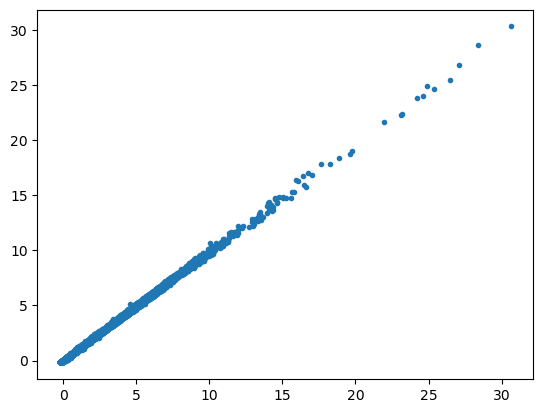

In [100]:
import matplotlib.pyplot as plt
plt.plot(labels.view(-1).detach().numpy(), model(data).view(-1).detach().numpy(),'.')
plt.show()

In [102]:
lorentz_loss = LorentzLoss(model=model,device='cpu')
sample = torch.randn([1, 100* 4],requires_grad=True)  # Using a batch size of 10

lorentz_loss(sample,spin='scalar')


TypeError: super(type, obj): obj must be an instance or subtype of type

In [103]:
1.4/len(data.view(-1))

3.5e-06

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
import math


In [20]:
class SimpleNet(nn.Module):
    def __init__(self,d_in,d_hidden,depth):
        super(SimpleNet,self).__init__()

        
        self.fc_in = nn.Linear(d_in,d_hidden)
        self.fcs = nn.ModuleList([])
        for _ in range(depth):
            self.fcs.append(nn.Linear(d_hidden,d_hidden))
            self.fcs.append(nn.ReLU())

        self.fcs = nn.Sequential(*self.fcs)

        
        self.fc_out = nn.Linear(d_hidden,1)

    def forward(self,x):
        x = self.fc_in(x)
        x = self.fcs(x)
        return self.fc_out(x)

        

In [144]:
data = torch.randn([1000,2])
labels = torch.norm(data,2,dim=-1)


In [443]:
iters=100000
inds = torch.randint(0,10,(iters,1000))
inds.shape
data_split = data[inds]
labels_split = labels[inds]


for i, (ins,lbls) in enumerate(zip(data_split, labels_split)):
    
    preds = model(ins).view(-1)
    loss = criterion(preds,lbls.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%10000==0:
        print(f'iter: {i} \tloss: {loss}')


iter: 0 	loss: 0.0006657767808064818
iter: 10000 	loss: 2.7011161364498548e-05
iter: 20000 	loss: 5.571808742388384e-06
iter: 30000 	loss: 1.3434574839266133e-06
iter: 40000 	loss: 3.014030482972885e-07
iter: 50000 	loss: 1.0394474969643852e-07
iter: 60000 	loss: 7.645576260983944e-08
iter: 70000 	loss: 8.625303848930344e-08
iter: 80000 	loss: 1.0606062517126702e-07
iter: 90000 	loss: 9.90399158240507e-08


In [370]:
import torch
import torch.nn as nn
import torch.optim as optim


from torch.utils.data import DataLoader, TensorDataset

# Data
data = torch.randn([2000, 2])
labels = torch.norm(data, 2, dim=-1, keepdim=True)  # Ensuring labels have the same shape
labels += labels**2/2

In [371]:
data=data[labels.view(-1)>2,:]
labels=labels[labels.view(-1)>2]
data.shape

torch.Size([908, 2])

In [439]:
model = SimpleNet(2,8,8)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4,weight_decay=3e-4,momentum=0.6)
# Training loop
num_epochs = 10000
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                       max_lr = 8e-3, # Upper learning rate boundaries in the cycle for each parameter group
                       
                       total_steps=num_epochs,
                       div_factor = 25,
                       final_div_factor = 25,
                    #    steps_per_epoch = 8, # The number of steps per epoch to train for.
                    #    epochs = 4, # The number of epochs to train for.
                       anneal_strategy = 'cos') # Specifies the annealing strategy



# torch.
model.train()



# Creating TensorDataset
dataset = TensorDataset(data, labels)

# Creating DataLoader
dataloader = DataLoader(dataset, batch_size=500, shuffle=True)


for epoch in range(num_epochs):
    for i, (ins, lbls) in enumerate(dataloader):
        optimizer.zero_grad()
        
        preds = model(ins).view(-1)
        loss = criterion(preds, lbls.view(-1))

        
        loss.backward()
        optimizer.step()
    scheduler.step()

    if epoch % 1000 == 0:  # Adjust print frequency as needed
        print(f'Epoch: {epoch+1}, lr: {scheduler.get_last_lr()}, Loss: {loss.item()}')


Epoch: 1, lr: [0.00032000210691979225], Loss: 17.15064239501953
Epoch: 1001, lr: [0.0022446467459712105], Loss: 0.00806010328233242
Epoch: 2001, lr: [0.0060858031641032855], Loss: 0.002568536438047886
Epoch: 3001, lr: [0.007999998391214307], Loss: 0.002234270330518484
Epoch: 4001, lr: [0.0076029525015640954], Loss: 0.003955607768148184
Epoch: 5001, lr: [0.006493565280157327], Loss: 0.0014279878232628107
Epoch: 6001, lr: [0.004891564471935003], Loss: 0.0013319478603079915
Epoch: 7001, lr: [0.0031142459842161186], Loss: 0.0012666907859966159
Epoch: 8001, lr: [0.001513629540874196], Loss: 0.001044192467816174
Epoch: 9001, lr: [0.00040673685878554316], Loss: 0.0008776861941441894


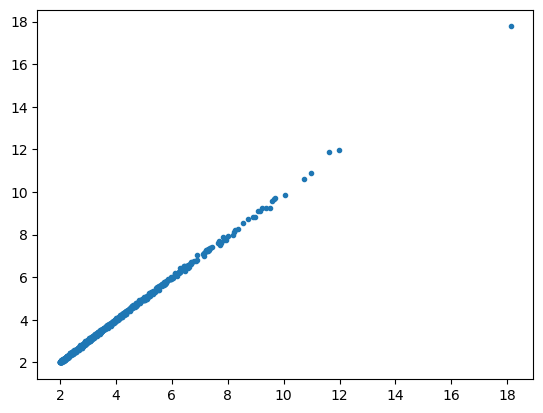

In [445]:
import numpy as np
import matplotlib.pyplot as plt


plt.plot(labels.view(-1).detach().numpy(),model(data).view(-1).detach().numpy(),'.')
plt.show()

In [21]:
a=[2,5,4]
a.sort()
a

[2, 4, 5]

In [446]:
model.eval()
data_g = data.clone().detach().requires_grad_(True)
outs = model(data_g)
grads = torch.autograd.grad(outputs=outs,inputs=data_g,grad_outputs=torch.ones_like(outs))[0]


In [447]:
import einops
data_g.requires_grad_=False
gx=einops.rearrange(torch.einsum('ai,aj->aij',data_g,grads), 'a i j -> a (i j)')
gxgx = torch.einsum('ai,aj->aij',gx,gx)



gxgx_mean = torch.mean(gxgx,dim=0).detach()
gxgx_mean

eig = torch._linalg_eigh(gxgx_mean)
eig.eigenvectors[:,0].view(2,2), eig.eigenvalues


(tensor([[-3.7164e-03,  7.0416e-01],
         [-7.1003e-01,  2.0667e-04]]),
 tensor([ 0.1575,  9.1362,  9.8799, 19.2056]))

In [392]:
eig.eigenvectors[:,0] @ eig.eigenvectors[:,0]

tensor(1.0000)

In [225]:
mod = nn.Linear(len(gxv[0]),len(gxv[0]),bias=False)
mod.train()

Linear(in_features=9, out_features=9, bias=False)

In [226]:
optimizer = torch.optim.SGD(mod.parameters(), lr=0.01) 

In [333]:
x = torch.randn([1000000,2],requires_grad=True)
y = torch.norm(x,2,keepdim = True,dim = -1)
g = torch.autograd.grad(y,x,torch.ones_like(y))[0].detach()
x = x.detach()

xg = einops.rearrange(torch.einsum('ij, ik ->ijk',x,g), 'i j k -> i (j k)')

# xg.requires_grad_=False
xgxg = torch.einsum('ij, ik -> ijk',xg,xg)
xgxg_mean = torch.mean(xgxg,dim=0)
eig=torch.linalg.eig(xgxg_mean)

In [334]:
xgxg.shape

torch.Size([1000000, 4, 4])

In [335]:
(xgxg_mean @ torch.real(eig.eigenvectors[:,-1]))/torch.real(eig.eigenvectors[:,-1])

tensor([-1.9779,  0.0000, -0.0000,  0.7249])

In [281]:
eig=torch._linalg_eigh(xgxg_mean)

(xgxg_mean @ (eig.eigenvectors[:,0]) )/eig.eigenvectors[:,0]

tensor([ 3.2282e-01, -1.0537e-07,  1.2644e-07,  6.0522e-01])

In [283]:
ev1=eig.eigenvectors[:,0]
ev1.view(2,2)

tensor([[-1.8572e-08, -7.0711e-01],
        [ 7.0711e-01,  3.1325e-08]])

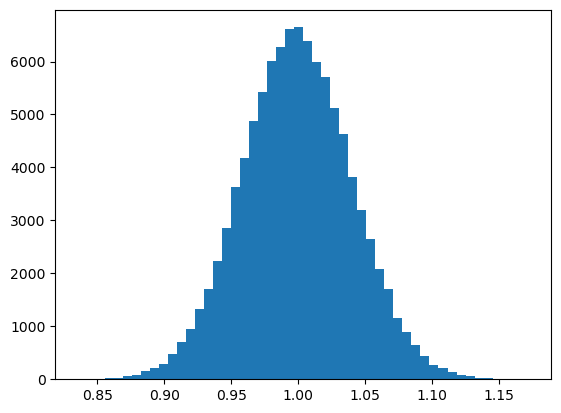

In [311]:
plt.hist(torch.norm(torch.randn([100000,300]),2,dim=-1)/math.sqrt(300),50)
plt.show()

In [319]:
torch.mean(torch.norm(torch.randn([1000000,300]),2,dim=-1)**2)

tensor(299.9980)

In [332]:
bin(23452)[2:]

'101101110011100'